# Import Necessary Modules/Packages

In [1]:
!pip install GPy
!pip uninstall -y ipdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 23.8 MB/s 
     |████████████████████████████████| 71 kB 10.7 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565166 sha256=ab87669a0a734b06bcfc3823487ca03e8607ed5270dd0bfcf9ceb70ed8654692
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=ec20881f4946961bf3c4f92c3e1f46db4cda66a50e50c322fdf89aa867c24b61
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [2]:
import GPy
import numpy as np
import math # math operation
from matplotlib import pyplot as plt # make plot
#import random
from tqdm import tqdm
import timeit
import copy
%matplotlib inline
%load_ext autoreload
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import pickle
import itertools
import pandas as pd


# Try and error

In [3]:
# k = GPy.kern.RBF(1, variance=7., lengthscale=0.2)
# X = np.random.rand(200,1)
# x = np.random.rand(1,1)
# #draw the latent function value
# f = np.random.multivariate_normal(np.zeros(200), k.K(X))

# lik = GPy.likelihoods.Bernoulli()
# p = lik.gp_link.transf(f) # squash the latent function
# Y = lik.samples(f).reshape(-1,1)
# m = GPy.core.GP(X=X,
#                 Y=Y, 
#                 kernel=k, 
#                 inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
#                 likelihood=lik)

In [4]:
# X1,p1 = zip(*sorted(zip(X, p)))
# plt.plot(X1,p1)

# Data Processing

In [5]:
filename = 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

In [6]:
df = pd.read_csv(filename) 
df.tail()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
70691,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,2.0


In [7]:
col_name = []
for name in df.columns:
    col_name.append(name)

In [8]:
X = df.to_numpy()[:,1:]
y = df.to_numpy()[:,0]

In [9]:
from sklearn.model_selection import train_test_split

r = 1 - 0.7073
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r, random_state = 123)

# X_train, y_train, X_test, y_test = X_train[:2000], y_train[:2000], X_test[:1000], y_test[:1000]

In [10]:
print(f"train len {len(X_train)}, test len {len(X_test)}")

train len 50000, test len 20692


Visualization

Text(0.5, 1.0, 'Diabeties')

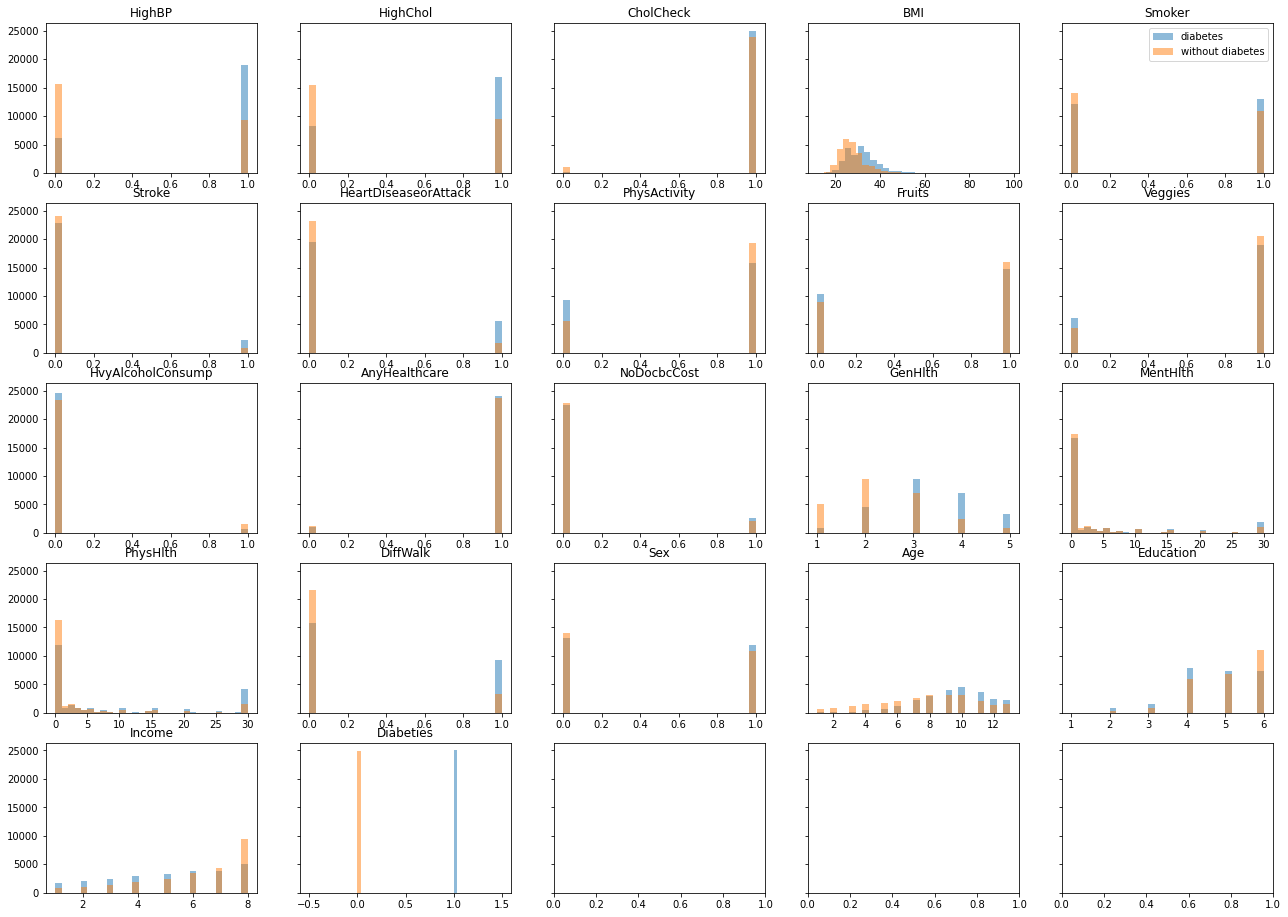

In [11]:
a = 5
b = 5

fig, axs = plt.subplots(a, b, figsize=(22, 16), sharey=True)
rows = [i for i in range(a)]
cols = [i for i in range(b)]
indices = list(itertools.product(*[rows, cols]))
for i, ind in zip(range(X.shape[1]), indices):
  r,c = ind
  pos = X_train[np.where(y_train == 1)]
  neg = X_train[np.where(y_train == 0)]
  axs[r,c].hist(pos[:,i],bins = 30, alpha = 0.5, label= "diabetes")
  axs[r,c].hist(neg[:,i],bins = 30, alpha = 0.5,label= "without diabetes")
  axs[r,c].set_title(col_name[i+1])
  if r == 0 and c == 4:
    axs[r,c].legend(loc='upper right')


# label
r = 4
c = 1
pos = y_train[np.where(y_train == 1)]
neg = y_train[np.where(y_train == 0)]
axs[r,c].hist(pos,bins = 30, alpha = 0.5, label= "diabetes")
axs[r,c].hist(neg,bins = 30, alpha = 0.5,label= "without diabetes")
axs[r,c].set_title("Diabeties")


In [12]:
for ind in range(X.shape[1]):
  pos_pos = X_train[np.where((X_train[:,ind] == 1) & (y_train == 1))]
  pos = X_train[np.where(X_train[:,ind] == 1)]
  try:
    print(f"{col_name[ind+1]}: pos_pos:{len(pos_pos[:,ind])/len(pos[:,ind])}")
  except:
    print(f"{col_name[ind+1]}: we do not use it")

HighBP: pos_pos:0.6696688178143394
HighChol: pos_pos:0.6380181617842623
CholCheck: pos_pos:0.5111708347865335
BMI: we do not use it
Smoker: pos_pos:0.5462966844112839
Stroke: pos_pos:0.7370952228278295
HeartDiseaseorAttack: pos_pos:0.7590589507842077
PhysActivity: pos_pos:0.45016644379321136
Fruits: pos_pos:0.47968463752944257
Veggies: pos_pos:0.4807155544278102
HvyAlcoholConsump: pos_pos:0.27808727948003714
AnyHealthcare: pos_pos:0.5040500659313059
NoDocbcCost: pos_pos:0.5687031082529475
GenHlth: pos_pos:0.13703954038526528
MentHlth: pos_pos:0.4013651877133106
PhysHlth: pos_pos:0.43102601865488466
DiffWalk: pos_pos:0.7333439212260779
Sex: pos_pos:0.5256977610305393
Age: pos_pos:0.09339080459770115
Education: pos_pos:0.625
Income: pos_pos:0.6597575283535393


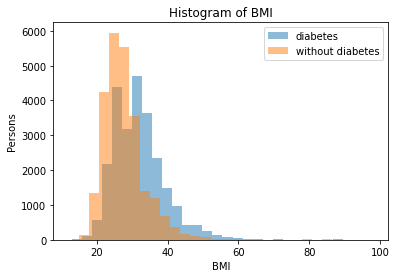

In [14]:
pos = X_train[np.where(y_train == 1)]
neg = X_train[np.where(y_train == 0)]
plt.hist(pos[:,3],bins = 30, alpha = 0.5, label= "diabetes")
plt.hist(neg[:,3],bins = 30, alpha = 0.5,label= "without diabetes")
plt.ylabel("Persons")
plt.xlabel("BMI")


plt.title("Histogram of BMI")
plt.legend()

# Cross validation function

In [ ]:
def cross_valid(x, y, k_fold = 5):


    # set seed
    #seed = 123
    #np.random.seed(seed)

    hypers = {'Outputscale': [0.1,1,5,10,30],'Lengthscale': [0.1,1,5,10,30]}
    tmp = [hypers['Outputscale'], hypers['Lengthscale']]
    hyperset = list(itertools.product(*tmp))
    #debug
    hyper_error = []

    k = k_fold # 5 folds
    size, subsize = x.shape[0], x.shape[0]//k
    ind = [i for i in range(len(x))]
    #np.random.shuffle(ind)

    models_cv_loss = np.zeros((k,len(hyperset)))
    for i in range(k):
      if i != (k-1):
        sta, end = subsize * i, subsize*(i+1)
      else:
        sta, end = subsize * i, None
      #print(f"\n sta: {sta}; end {end}")
      for m in range(len(hyperset)):
        # shuffle index
        ind_all = [j for j in range(size)]
        test_ind = ind[sta:end]
        train_ind = [ind for ind in ind_all if ind not in test_ind]

        
        
        train_x = x[train_ind]

        try:
          # fit model
          model = model_build(x = train_x,y = y[train_ind],kernel_par= hyperset[m])

          # Evaluation 

          test_x = x[test_ind]
          test_y = y[test_ind]

          pred_y,_ = model.predict(test_x, full_cov=False, include_likelihood=True)
          pred_y[pred_y >= 0.5] = 1
          pred_y[pred_y < 0.5] = 0
          loss = np.mean(pred_y.reshape(-1,1) != test_y.reshape(-1,1))


          # This is another loss calculation method
          # one_vec = np.array([1 for i in range(len(pred_y))])
          # pred_y_label = np.random.binomial(one_vec, pred_y.reshape(-1))
          # loss = np.mean(pred_y_label.reshape(-1,1) != test_y.reshape(-1,1))

          models_cv_loss[i,m] = loss


        # Try except is to avoid some mis-behalfed hyerparameters
        except:
          hyper_error.append(hyperset[m])
          models_cv_loss[i,m] = float('inf')
          print(f"The hyperpar with exception: {hyper_error}")
          

        
      # if i == 0: 
      #   print(f"\n sample size: {x.shape[0]}; train size: {train_x.shape}; test size: {test_x.shape}\n")
    loss = np.mean(models_cv_loss, axis = 0)
    optimhyper = hyperset[np.argmin(loss)]
    return loss, optimhyper
      


# Full Model


In [ ]:
def model_build(x,y,kernel_par, seed = 123):
  """
  1.Descrption:
          This function is to build models with different hyperparameters
  
  2. input arguments and output:
      Input arguments:
          x: Features
          y: True response value
          kernel: String. Square_exp or Matern
          kernel_par: A tuple. (outputscale, lengthscale, noise)
          seed: Int. To make result reproducible
          iter_num: Int. Number of epochs for training
      Output:
          model and likelihood

  """
  # kernel = "square_exp",
  # set seed
  np.random.seed(seed)



  # build model
  outputscale, lenscale = kernel_par
  lik = GPy.likelihoods.Bernoulli()
  _, dim = x.shape
  kernel = GPy.kern.RBF(input_dim=dim,variance= outputscale,lengthscale= lenscale)
  model = GPy.core.GP(x,
                      y.reshape(-1,1),
                      kernel = kernel, 
                      inference_method=GPy.inference.latent_function_inference.Laplace(),
                      likelihood=lik)

  #m.optimize('bfgs', max_iters=100) Because CV applied, we did not used the optimize  
  return model

# Distributed Method Specification

In [ ]:
np.unique(X_train[:,20] )

array([1., 2., 3., 4., 5., 6., 7., 8.])

##spa (for case study)

In [ ]:
def feature(X_train, y_train,k):
  rslt_x = []
  rslt_y = []
  uniq_lst = np.unique(X_train[:,k])
  for i in uniq_lst:
    x, y  = X_train[np.where((X_train[:,k] == i))], y_train[np.where((X_train[:,k] == i))]
    rslt_x.append(x)
    rslt_y.append(y)
  return rslt_x, rslt_y


def feature_bmi_spa(X_train, y_train, n, k):
  """
  output:
    itv: a list including upper bound
    mx: features split into m chunks
    my: labels split into m chunks
  """

  rslt_x, rslt_y = feature(X_train, y_train,k)

  itv_container = []
  mx_container = []
  my_container = []
  count = []
  for x,y in zip(rslt_x, rslt_y):
    itv, mx, my = bmi_spa(x, y, n)
    itv_container.append(itv)
    mx_container.append(mx)
    my_container.append(my)
    count.append(len(mx))



  count = np.array(count)
  print(f"sum of {count} is {np.sum(count)}")

  return itv_container, mx_container, my_container


def bmi_spa(X_train, y_train, n = 90):
  """
 BMI is used in spatial method
  """
  lst = [] # the upper bound of the interval
  # n = 700 m = 40
  # n = 1900 m = 25 for hel
  # n = 232 m = 100 for hel
  # n =  m = 90 for income
  total_num = 0
  mx = []
  my = []
  count = 0
  for i in range(981): #max BMI is 98
    i = i/10
    ind1 = np.where((X_train[:,3] <= i))
    
    if (not lst) and (len(X_train[ind1]) >= n):
      lst.append(i)
      total_num += len(X_train[ind1])
      mx.append(X_train[ind1])
      my.append(y_train[ind1])
      print(f"{count}th machine: len(y_train[ind1]) {len(y_train[ind1])} ")
      count+=1
    elif lst:
      ind2 = np.where((X_train[:,3] <= i ) & (X_train[:,3] > lst[-1]))
      ind3 = np.where((X_train[:,3] > lst[-1]))
      if (len(X_train[ind2]) > n):
        lst.append(i)
        total_num += len(X_train[ind2])
        mx.append(X_train[ind2])
        my.append(y_train[ind2])
        print(f"{count}th machine: len(y_train[ind2]) {len(y_train[ind2])} ")
        count+=1
      if len(X_train[ind3]) < n:
        lst.append(i)
        total_num += len(X_train[ind3])
        mx.append(X_train[ind3])
        my.append(y_train[ind3])
        print(f"{count}th machine: len(y_train[ind3]) {len(y_train[ind3])}")
        count+=1
        lst[-1] = float('inf')
        break
  print(f"{count} machines required")

  return lst, mx, my



def sorted_bmi__x_y(x,y):
    test_x = copy.deepcopy(x)
    test_y = copy.deepcopy(y)
    ind = np.argsort(test_x[:,3])
    test_x_sorted = test_x[ind]
    test_y_sorted = test_y[ind]
    return test_x_sorted, test_y_sorted



def prediction_spa_bmi(test_x,interval,modelcontainer = None):


    # test_x = copy.deepcopy(test_x)
    # ind = np.argsort(test_x[:,3])
    # test_x = test_x[ind]
    m = len(interval)



    mean = []
    var = []
    x_m = [[] for i in range(m)]


    for ob in test_x:
      for i in range(len(interval)):
        if ob[3] <= interval[i]:
          x_m[i].append(ob)
          break
    x_m = [np.array(array) for array in x_m]

    for i in range(len(x_m)):
      model = modelcontainer[i] 

      # mean_spa means the predicted mean
      try:
        for ob in x_m[i]:
          mean_spa, var_spa = model.predict(ob.reshape(1,-1), full_cov=True, include_likelihood=False)
          mean.append(mean_spa)
          var.append(var_spa)
      except:
        print(f"Error happen")
        print(interval)
        print(x_m[i])


      

    #y_flaten = np.array([j for i in y for j in i])
    return  x_m, var, mean


def distributed_spa(x_container,y_container):
    """
    x_container,y_container: list of list with observaations.
    """
    m = len(x_container)

    model_container = []

    for i in tqdm(range(m)):
              
      m_x = x_container[i]
      m_y = y_container[i]
      if len(m_x)<5:
        k_spa =  len(m_x)
        print(f"k_spa {k_spa}")
      else:
        k_spa = 5
      _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
      #print(f"optim is {optim}")
      model = model_build(x = m_x,y = m_y.reshape(-1,1),kernel_par= optim)
      model_container.append(model)
    return model_container


def derive_pi_spa(mean_lst,var_lst,simu_num = 200,seed = 212):
    """
    To get pi from laten f for spatial method
    """
    prob = []
    for mean, var in tqdm(zip(mean_lst,var_lst)):
      #print(f"mean is {mean}")
      p = derive_pi_margin(mean,var,simu_num,seed)
      prob.append(p)
    print(f"The p list has length of {len(prob)}")
    return np.array(prob)

## general

In [ ]:
def distributed_model(x, y, machine_num = 10, seed = 213, mode = "naiveAvg"):


    # set seed
    np.random.seed(seed)

    m = machine_num #  machines
    size, subsize = x.shape[0], x.shape[0]//m
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)
    
    count_size = []

    
    model_container = []
    if mode == "naiveAvg":

      for i in tqdm(range(m)):

          if i != (m-1):
            sta, end = subsize * i, subsize*(i+1)
          else:
            sta, end = subsize * i, None
          # print(f"\n {i}th machine")

        
          indice = ind[sta:end]
          m_x = x[indice]
          count_size.append(len(m_x))
          
          m_y = y[indice]

          _, optim = cross_valid(m_x, m_y, k_fold = 5)
          #print(f"optim is {optim}")
          model = model_build(x = m_x,y = m_y.reshape(-1,1),kernel_par= optim)
          model_container.append(model)
      print(f"machine num {len(count_size)}; All have the same subsample size: {count_size.count(count_size[0]) == len(count_size)}\n")
      
    elif mode == "adjPrior":

      for i in tqdm(range(m)):

        if i != (m-1):
          sta, end = subsize * i, subsize*(i+1)
        else:
          sta, end = subsize * i, None
        #print(f"\n {i}th machine: \n sta: {sta}; end {end}")
        
      
        indice = ind[sta:end]
        m_x = x[indice]
        count_size.append(len(m_x))
        m_y = y[indice]
        _, optim = cross_valid(m_x, m_y, k_fold = 5) 
        

        outscale, lenscale = optim
        #print(f"optim is {optim}")
        model = model_build(x = m_x,y = m_y.reshape(-1,1),kernel_par= (m*outscale, lenscale))
        model_container.append(model)

      print(f"machine num {len(count_size)}; All have the same subsample size: {count_size.count(count_size[0]) == len(count_size)}\n")
    # elif mode == "spa":
    #   _, m_x_lst, m_y_lst = To_interval(x, y, m = m)

    #   for i in range(m):
                 
    #       m_x = m_x_lst[i]
    #       m_y = m_y_lst[i]
    #       if len(m_x)<5:
    #         k_spa =  len(m_x)
    #         print(f"k_spa {k_spa}")
    #       else:
    #         k_spa = 5
    #       _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
    #       #print(f"optim is {optim}")
    #       model = model_build(x = m_x,y = m_y.reshape(-1,1),kernel_par= optim)
    #       model_container.append(model)


    return model_container
# derive cov and mean for each machine:


def derive_cov_mean(x,model_container):
    """
    derive mean and cov of latent f for each machine
    """
    test_x = x
    mean_container = []
    cov_container = []
    for model in model_container:
      mean, cov = model.predict(test_x, full_cov = True, include_likelihood = False)
      mean_container.append(mean)
      cov_container.append(cov)
    
    return mean_container, cov_container



def combine_method(mean_container, cov_container, mode):
    """
    Take averge of mean of predictive distribution from all machine
    Take averge of covariance of predictive distribution from all machine
    predictive distribution is p(f*|x,y,x*)

    """
    print(f"combine_method!")
    mean_container = np.array(mean_container)
    cov_container = np.array(cov_container)
    combine_mean = np.mean(mean_container,axis = 0)

    if mode == "naiveAvg":
      combine_cov = np.mean(cov_container,axis = 0)/len(mean_container)
    elif mode == "adjPrior":
      combine_cov = np.mean(cov_container,axis = 0)

    return combine_mean,combine_cov


# derive combined cov and mean:

def get_full_par(x,y,test_x, mode,machine_num):
  """
  The function is derived combined mean and covariance of latent f
  x,y: train data
  mode is either naiveAvg or adjPrior
  """
  print(f"get_full_par!")
  model_container = distributed_model(x,y, mode = mode,machine_num = machine_num)

  # mean_lst = []
  # cov_lst = []
  # for test_ob in test_x:
  #   est_para = derive_cov_mean(test_ob,model_container)
  #   mean, cov = combine_method(*est_para, mode = mode)
  #   mean_lst.append(mean)
  #   cov_lst.append(cov)


  est_para = derive_cov_mean(test_x,model_container)
  mean, cov = combine_method(*est_para, mode = mode)
  return mean, cov
  # return mean_lst, cov_lst






def derive_pi(mean,cov,simu_num = 200,seed = 212):
    """

    Monte Carlo integration is applied
    transform f into p(y =1|x)

    """
    print(f"derive_pi!")
    np.random.seed(seed)
    contianer = []
    for i in tqdm(range(simu_num)):
        f_str = np.random.multivariate_normal(mean.reshape(-1), cov)
        realizatoin =  norm.cdf(f_str)
        contianer.append(realizatoin)

      

    rslt = np.array(contianer)
    prob = np.mean(rslt, axis=0)
    return prob

# The following pi function is for case study because size of test data is too large


def derive_pi_margin(mean,var,simu_num = 1000,seed = 212):
    """
    Monte Carlo integration is applied
    transform f into p(y =1|x)
    """
    np.random.seed(seed)
    
    sigma = np.sqrt(var)
    f_str = np.random.normal(mean.reshape(-1), (sigma.reshape(-1)), simu_num)
    realizatoin =  norm.cdf(f_str)

    prob = np.mean(realizatoin)
    return prob


def get_prob(test_x, mode,model_container):
    """
    The function is derived combined mean and covariance of latent f
    x,y: train data
    mode is either naiveAvg or adjPrior
    """
    prob_lst = []
    for test_ob in tqdm(test_x):
      mean_container, var_container = derive_cov_mean(test_ob.reshape(1,-1), model_container)
      mean, var = np.mean(np.array(mean_container)), np.mean(np.array(var_container))

      p = derive_pi_margin(mean,var)
      prob_lst.append(p)
    return np.array(prob_lst)

# Metrics

In [ ]:
def get_confusion_matrix(test_y1, pred_y):
  predy_dist =  copy.deepcopy(pred_y)
  predy_dist[predy_dist >= 0.5] = 1
  predy_dist[predy_dist < 0.5] = 0
  return confusion_matrix(test_y1, predy_dist, labels=[0,1])


# The complete simlation experiment

In [ ]:
def main_fun(x,y, test_x,test_y, k = 0, n = 700, mode = "naiveAvg", machine_num = 40):
  """
  The goal is to derive the plot, model, result from all kinds of distributed models
  Method: naive, adjPrior, spa


  Output: 
  """

  rslt = {"time": None, "confusion": None, "p":None}

  if mode == "spa":
    start = timeit.default_timer()
    model_con_con = []
    itv_container, mx_container, my_container = feature_bmi_spa(x, y, n, k)
    for mx, my in zip(mx_container, my_container):
      
      model_container = distributed_spa(mx, my)
      model_con_con.append(model_container)
    stop = timeit.default_timer()
    time = stop - start
    rslt["time"] = time

    # derive sorted x coordinate, spa cov and mean list
    testx_container = []
    testy_container = []

    uniq_lst = np.unique(test_x[:,k])
    for i in uniq_lst:
      test_x_spa = test_x[np.where(test_x[:,k] == i)]
      test_y_spa = test_y[np.where(test_x[:,k] == i)]
      testx_container.append(test_x_spa)
      testy_container.append(test_y_spa)
      

 
    p_flatten_spa_container = []

    tn, fp, fn, tp = 0, 0, 0, 0


    for itv, test_x_spa, test_y_spa, model_container in zip(itv_container, testx_container, testy_container,model_con_con):
      test_x_spa, test_y_spa = sorted_bmi__x_y(test_x_spa, test_y_spa)
      x_spa, cov_spa, mean_spa  = prediction_spa_bmi(test_x_spa, itv, model_container)
      p_flatten_spa = derive_pi_spa(mean_spa, cov_spa, simu_num = 1000, seed = 212)
      tn0, fp0, fn0, tp0 = get_confusion_matrix(test_y_spa, p_flatten_spa).ravel()
      
      tn += tn0
      fp += fp0
      fn += fn0
      tp += tp0
      p_flatten_spa_container.append(p_flatten_spa)    


    rslt["p"] = p_flatten_spa_container
    

    rslt["confusion"] = (tn, fp, fn, tp)

  elif mode == "full":
    start = timeit.default_timer()

    _, optim = cross_valid(x, y, k_fold = 5)
    model = model_build(x = x,y = y.reshape(-1,1), kernel_par= optim)

    stop = timeit.default_timer()
    time = stop - start
    rslt["time"] = time



    prob_lst = []
    for test_ob in tqdm(test_x):
      mean, var = model.predict(test_ob.reshape(1,-1), full_cov = True, include_likelihood = False)
      p = derive_pi_margin(mean,var)
      prob_lst.append(p)
    p = np.array(prob_lst)
    tn, fp, fn, tp = get_confusion_matrix(test_y, p).ravel()
    rslt["p"] = p
    rslt["confusion"] = (tn, fp, fn, tp)
    

  elif mode != "spa":
    start = timeit.default_timer()
    model_container = distributed_model(x,y, mode = mode,machine_num = machine_num)

    stop = timeit.default_timer()
    time = stop - start
    rslt["time"] = time

    p  = get_prob(test_x, mode,model_container)
    rslt["p"] = p
    tn, fp, fn, tp = get_confusion_matrix(test_y, p).ravel()

    rslt["confusion"] = (tn, fp, fn, tp)
  
  else:
    print(f"Wrong mode!")
  return rslt

  

# Implementation 0 (Full model)

In [ ]:
# modes = ['full']

# m = 1
# print(f"len X_train {len(X_train)}; len y_train {len(y_train)}")
# result_container = dict()
# for mode in modes:
    
#   rslt = main_fun(X_train, y_train, X_test, y_test, k = 0, n = 700, mode = mode, machine_num = m)
#   result_container[mode] = rslt

#   print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
#   with open(f'rslt_{mode}_csdy.pickle', 'wb') as handle:
#       pickle.dump(result_container, handle)

len X_train 50000; len y_train 50000


# Implementation 1 (m = 40)

In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['spa']

m = 40

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, k = 0, n = 700, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

0th machine: len(y_train[ind1]) 1303 
1th machine: len(y_train[ind2]) 984 
2th machine: len(y_train[ind2]) 1312 
3th machine: len(y_train[ind2]) 1458 
4th machine: len(y_train[ind2]) 1848 
5th machine: len(y_train[ind2]) 1539 
6th machine: len(y_train[ind2]) 1761 
7th machine: len(y_train[ind2]) 2058 
8th machine: len(y_train[ind2]) 1393 
9th machine: len(y_train[ind2]) 1246 
10th machine: len(y_train[ind2]) 1169 
11th machine: len(y_train[ind2]) 952 
12th machine: len(y_train[ind2]) 875 
13th machine: len(y_train[ind2]) 719 
14th machine: len(y_train[ind2]) 1007 
15th machine: len(y_train[ind2]) 953 
16th machine: len(y_train[ind2]) 737 
17th machine: len(y_train[ind3]) 484
18 machines required
0th machine: len(y_train[ind1]) 1004 
1th machine: len(y_train[ind2]) 1545 
2th machine: len(y_train[ind2]) 1234 
3th machine: len(y_train[ind2]) 1301 
4th machine: len(y_train[ind2]) 1761 
5th machine: len(y_train[ind2]) 2299 
6th machine: len(y_train[ind2]) 1863 
7th machine: len(y_train[ind2

100%|██████████| 22/22 [1:05:23<00:00, 178.34s/it]
9062it [00:02, 3596.11it/s]


The p list has length of 9062


11630it [00:03, 3682.53it/s]

The p list has length of 11630

 We finished in mode = spa, Time:6918.75, Metrics: (7263, 3170, 2144, 8115)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ["naiveAvg"]

m = 40
result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)



100%|██████████| 40/40 [1:37:20<00:00, 146.00s/it]


machine num 40; All have the same subsample size: True



100%|██████████| 20692/20692 [17:59<00:00, 19.17it/s]


 We finished in mode = naiveAvg, Time:5840.08, Metrics: (7421, 3012, 2159, 8100)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['adjPrior']

m = 40
result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 40/40 [1:41:36<00:00, 152.41s/it]


machine num 40; All have the same subsample size: True



100%|██████████| 20692/20692 [18:14<00:00, 18.91it/s]


 We finished in mode = adjPrior, Time:6096.35, Metrics: (7303, 3130, 1974, 8285)
 


# Implementation 2 (m = 25)


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['spa']

m = 25

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, k = 13, n = 1900, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

0th machine: len(y_train[ind1]) 2496 
1th machine: len(y_train[ind2]) 1954 
2th machine: len(y_train[ind3]) 1468
3 machines required
0th machine: len(y_train[ind1]) 2521 
1th machine: len(y_train[ind2]) 2053 
2th machine: len(y_train[ind2]) 2648 
3th machine: len(y_train[ind2]) 2775 
4th machine: len(y_train[ind2]) 1979 
5th machine: len(y_train[ind2]) 1904 
6th machine: len(y_train[ind3]) 182
7 machines required
0th machine: len(y_train[ind1]) 2595 
1th machine: len(y_train[ind2]) 3305 
2th machine: len(y_train[ind2]) 2128 
3th machine: len(y_train[ind2]) 2120 
4th machine: len(y_train[ind2]) 2578 
5th machine: len(y_train[ind2]) 1918 
6th machine: len(y_train[ind3]) 1861
7 machines required
0th machine: len(y_train[ind1]) 2258 
1th machine: len(y_train[ind2]) 2358 
2th machine: len(y_train[ind2]) 2271 
3th machine: len(y_train[ind2]) 1963 
4th machine: len(y_train[ind3]) 555
5 machines required
0th machine: len(y_train[ind1]) 1952 
1th machine: len(y_train[ind2]) 1936 
2th machine: l

100%|██████████| 3/3 [11:33<00:00, 231.07s/it]
2364it [00:00, 3347.45it/s]


The p list has length of 2364


5810it [00:01, 3632.22it/s]


The p list has length of 5810


6922it [00:01, 3717.14it/s]


The p list has length of 6922


3898it [00:01, 3619.00it/s]


The p list has length of 3898


1698it [00:00, 3398.81it/s]


The p list has length of 1698

 We finished in mode = spa, Time:11098.01, Metrics: (7303, 3130, 2038, 8221)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['naiveAvg']

m = 25

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 25/25 [2:36:25<00:00, 375.40s/it]


machine num 25; All have the same subsample size: True



100%|██████████| 20692/20692 [17:01<00:00, 20.25it/s]



 We finished in mode = naiveAvg, Time:9385.05, Metrics: (7440, 2993, 2160, 8099)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['adjPrior']

m = 25

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 25/25 [2:41:40<00:00, 388.00s/it]


machine num 25; All have the same subsample size: True



100%|██████████| 20692/20692 [17:07<00:00, 20.14it/s]


 We finished in mode = adjPrior, Time:9700.07, Metrics: (7365, 3068, 2038, 8221)
 


# Implementation 3 (m = 100)


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['spa']

m = 100

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, k = 13,  n = 232, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

0th machine: len(y_train[ind1]) 403 
1th machine: len(y_train[ind2]) 350 
2th machine: len(y_train[ind2]) 519 
3th machine: len(y_train[ind2]) 572 
4th machine: len(y_train[ind2]) 652 
5th machine: len(y_train[ind2]) 488 
6th machine: len(y_train[ind2]) 525 
7th machine: len(y_train[ind2]) 580 
8th machine: len(y_train[ind2]) 361 
9th machine: len(y_train[ind2]) 313 
10th machine: len(y_train[ind2]) 298 
11th machine: len(y_train[ind2]) 343 
12th machine: len(y_train[ind2]) 283 
13th machine: len(y_train[ind3]) 231
14 machines required
0th machine: len(y_train[ind1]) 278 
1th machine: len(y_train[ind2]) 326 
2th machine: len(y_train[ind2]) 503 
3th machine: len(y_train[ind2]) 641 
4th machine: len(y_train[ind2]) 773 
5th machine: len(y_train[ind2]) 1028 
6th machine: len(y_train[ind2]) 1025 
7th machine: len(y_train[ind2]) 1204 
8th machine: len(y_train[ind2]) 1444 
9th machine: len(y_train[ind2]) 1011 
10th machine: len(y_train[ind2]) 858 
11th machine: len(y_train[ind2]) 906 
12th ma

100%|██████████| 14/14 [02:57<00:00, 12.69s/it]
2364it [00:00, 3455.85it/s]


The p list has length of 2364


5810it [00:01, 3624.54it/s]


The p list has length of 5810


6922it [00:01, 3713.96it/s]


The p list has length of 6922


3898it [00:01, 3598.81it/s]


The p list has length of 3898


1698it [00:00, 3453.68it/s]

The p list has length of 1698

 We finished in mode = spa, Time:3562.38, Metrics: (7154, 3279, 2114, 8145)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['naiveAvg']

m = 100

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 100/100 [45:52<00:00, 27.53s/it]


machine num 100; All have the same subsample size: True



100%|██████████| 20692/20692 [31:50<00:00, 10.83it/s]



 We finished in mode = naiveAvg, Time:2752.9, Metrics: (7364, 3069, 2146, 8113)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['adjPrior']

m = 100

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 100/100 [46:41<00:00, 28.01s/it]


machine num 100; All have the same subsample size: True



100%|██████████| 20692/20692 [31:50<00:00, 10.83it/s]



 We finished in mode = adjPrior, Time:2801.05, Metrics: (7154, 3279, 1853, 8406)
 


# Implementation 4 (m = 200)


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['spa']

m = 200

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, k = 20, n = 90, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

0th machine: len(y_train[ind1]) 108 
1th machine: len(y_train[ind2]) 162 
2th machine: len(y_train[ind2]) 104 
3th machine: len(y_train[ind2]) 119 
4th machine: len(y_train[ind2]) 116 
5th machine: len(y_train[ind2]) 128 
6th machine: len(y_train[ind2]) 188 
7th machine: len(y_train[ind2]) 138 
8th machine: len(y_train[ind2]) 147 
9th machine: len(y_train[ind2]) 159 
10th machine: len(y_train[ind2]) 127 
11th machine: len(y_train[ind2]) 108 
12th machine: len(y_train[ind2]) 102 
13th machine: len(y_train[ind2]) 95 
14th machine: len(y_train[ind2]) 93 
15th machine: len(y_train[ind2]) 161 
16th machine: len(y_train[ind2]) 119 
17th machine: len(y_train[ind2]) 123 
18th machine: len(y_train[ind2]) 108 
19th machine: len(y_train[ind2]) 100 
20th machine: len(y_train[ind3]) 52
21 machines required
0th machine: len(y_train[ind1]) 127 
1th machine: len(y_train[ind2]) 182 
2th machine: len(y_train[ind2]) 118 
3th machine: len(y_train[ind2]) 151 
4th machine: len(y_train[ind2]) 154 
5th machin

100%|██████████| 29/29 [21:05<00:00, 43.62s/it]
1054it [00:00, 3305.31it/s]


The p list has length of 1054


1325it [00:00, 3473.36it/s]


The p list has length of 1325


1704it [00:00, 3477.60it/s]


The p list has length of 1704


1884it [00:00, 3481.81it/s]


The p list has length of 1884


2343it [00:00, 3497.07it/s]


The p list has length of 2343


2963it [00:00, 3532.91it/s]


The p list has length of 2963


3275it [00:00, 3649.15it/s]


The p list has length of 3275


6144it [00:01, 3652.53it/s]

The p list has length of 6144

 We finished in mode = spa, Time:2857.27, Metrics: (7095, 3338, 2303, 7956)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['naiveAvg']

m = 200

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 200/200 [33:28<00:00, 10.04s/it]


machine num 200; All have the same subsample size: True



100%|██████████| 20692/20692 [56:12<00:00,  6.14it/s]


 We finished in mode = naiveAvg, Time:2008.62, Metrics: (7192, 3241, 2121, 8138)
 


In [ ]:
# modes = ["spa",'naiveAvg','adjPrior']
modes = ['adjPrior']

m = 200

result_container = dict()
for mode in modes:
    
  rslt = main_fun(X_train, y_train, X_test, y_test, mode = mode, machine_num = m)
  result_container[mode] = rslt

  print(f"\n We finished in mode = {mode}, Time:{round(rslt['time'],2)}, Metrics: {rslt['confusion']}\n ")


  
  with open(f'rslt_{mode}_csdy{m}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)

100%|██████████| 200/200 [33:47<00:00, 10.14s/it]


machine num 200; All have the same subsample size: True



100%|██████████| 20692/20692 [56:47<00:00,  6.07it/s]


 We finished in mode = adjPrior, Time:2027.55, Metrics: (6622, 3811, 1461, 8798)
 
